## 基于文本挖掘的企业隐患排查质量分析模型

### 赛题背景
企业自主填报安全生产隐患,对于将风险消除在事故萌芽阶段具有重要意义.企业在填报隐患时,往往存在不认真填报的情况,“虚报、假报”隐患内容,增大了企业监管的难度.
采用大数据手段分析隐患内容,找出不切实履行主体责任的企业,向监管部门进行推送,实现精准执法,能够提高监管手段的有效性,增强企业安全责任意识

### 数据说明

训练集数据包含"id、level_1（一级标准）、level_2（二级标准）、level_3（三级标准）、level_4（四级标准）、content（隐患内容）和label（标签）”共7个字段.
其中“id”为主键,无业务意义;“一级标准、二级标准、三级标准、四级标准”为《深圳市安全隐患自查和巡查基本指引（2016年修订版）》规定的排查指引,一级标准对应不同隐患类型,
二至四级标准是对一级标准的细化,企业自主上报隐患时,根据不同类型隐患的四级标准开展隐患自查工作;“隐患内容”为企业上报的具体隐患;“标签”标识的是该条隐患的合格性,
“1”表示隐患填报不合格,“0”表示隐患填报合格.

In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from collections import defaultdict
from torch.utils.data.dataloader import default_collate

In [6]:
def set_seed(seed):
    """PyTorch随机数种子设置大全"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)  # CPU上设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 当前GPU上设置随机种子
        # torch.cuda.manual_seed_all(seed) # 所有GPU上设置随机种子


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### 数据分析与处理

In [8]:
train = pd.read_csv('train.csv')  # 训练数据集
test = pd.read_csv('test.csv')  # 测试数据集
sub = pd.read_csv('sub.csv')  # 提交结果样例

print('train.shape=', train.shape)
print('test.shape=', test.shape)
print('sub.shape=', sub.shape)

train.shape= (12000, 7)
test.shape= (18000, 6)
sub.shape= (18000, 2)


In [9]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类（现场）—2016版,（二）电气安全,6、移动用电产品、电动工具及照明,1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类（现场）—2016版,（一）消防检查,2、防火检查,6、重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0


In [10]:
train.info()  # content列缺失值数为2(12000 - 11998)

train[train['content'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12000 non-null  int64 
 1   level_1  12000 non-null  object
 2   level_2  12000 non-null  object
 3   level_3  12000 non-null  object
 4   level_4  12000 non-null  object
 5   content  11998 non-null  object
 6   label    12000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 656.4+ KB


,id,level_1,level_2,level_3,level_4,content,label
6193,6193,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN,1
9248,9248,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,NaN,1


In [11]:
test.info()  # content列缺失值数为4(18000 - 17996)
test[test['content'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       18000 non-null  int64 
 1   level_1  18000 non-null  object
 2   level_2  18000 non-null  object
 3   level_3  18000 non-null  object
 4   level_4  18000 non-null  object
 5   content  17996 non-null  object
dtypes: int64(1), object(5)
memory usage: 843.9+ KB


,id,level_1,level_2,level_3,level_4,content
970,970,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
13006,13006,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
16845,16845,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
17742,17742,商贸服务教文卫类（现场）—2016版,（二）电气安全,1、配电房,2、配电房内电缆线应放置在电缆沟内，并应加设盖板。配电柜前后面应放置绝缘垫，其绝缘垫的长度应...,NaN


0    10712
1     1288
Name: label, dtype: int64


Text(0.5, 0, 'label count')

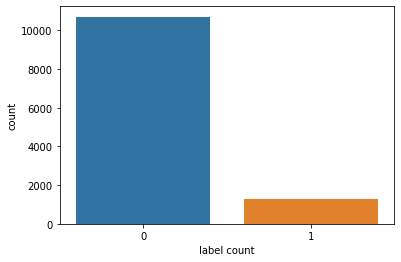

In [12]:
print(train['label'].value_counts())  # 正负样本不平衡(采用focal loss损失函数)

sns.countplot(data=train, x='label')
plt.xlabel('label count')

In [13]:
# 缺失值填充
train['content'] = train['content'].fillna('空值')
test['content'] = test['content'].fillna('空值')

In [14]:
# 去除同质部分
train['level_1'] = train['level_1'].apply(lambda x: x.split('（')[0])
train['level_2'] = train['level_2'].apply(lambda x: x.split('）')[-1])
train['level_3'] = train['level_3'].apply(lambda x: re.split(r'[0-9]、', x)[-1])
train['level_4'] = train['level_4'].apply(lambda x: re.split(r'[0-9]、', x)[-1])

test['level_1'] = test['level_1'].apply(lambda x: x.split('（')[0])
test['level_2'] = test['level_2'].apply(lambda x: x.split('）')[-1])
test['level_3'] = test['level_3'].apply(lambda x: re.split(r'[0-9]、', x)[-1])
test['level_4'] = test['level_4'].apply(lambda x: re.split(r'[0-9]、', x)[-1])

In [15]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0


In [16]:
# 字段拼接
train['text'] = train['content'] + '[SEP]' + train['level_1'] + '[SEP]' + train['level_2'] + '[SEP]' + train[
    'level_3'] + '[SEP]' + train['level_4']
test['text'] = test['content'] + '[SEP]' + test['level_1'] + '[SEP]' + test['level_2'] + '[SEP]' + test[
    'level_3'] + '[SEP]' + test['level_4']

In [17]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label,text
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.[SEP]工业/危化品类[SEP]电气安..."
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1,一般[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消...
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0,消防知识要加强[SEP]工业/危化品类[SEP]消防检查[SEP]防火检查[SEP]重点工种...


In [18]:
train['text_len'] = train['text'].map(len)
test['text_len'] = test['text'].map(len)

In [19]:
print(train['text_len'].describe(), end='\n\n')

print(test['text_len'].describe())

count    12000.000000
mean        80.439833
std         21.913662
min         43.000000
25%         66.000000
50%         75.000000
75%         92.000000
max        298.000000
Name: text_len, dtype: float64

count    18000.000000
mean        80.762611
std         22.719823
min         43.000000
25%         66.000000
50%         76.000000
75%         92.000000
max        520.000000
Name: text_len, dtype: float64


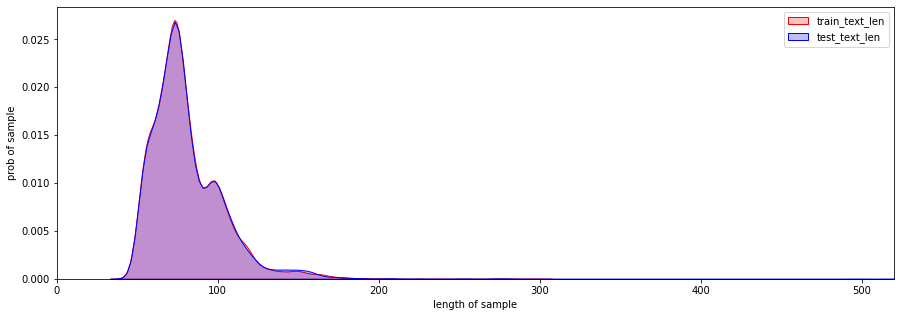

In [20]:
# 观察训练数据集与测试数据集分布情况(分布基本一直)
plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
sns.kdeplot(train['text_len'], ax=ax, color='red', fill=True)
sns.kdeplot(test['text_len'], ax=ax, color='b', fill=True)
ax.set_xlim([0, max(max(train['text_len']), max(test['text_len']))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_text_len', 'test_text_len'])

In [21]:
# 文本长度大部分(99.5%)在166以内(可以以此进行文本最大长度截断)
np.percentile(train['text_len'], q=99.5)

166.0

In [22]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [23]:
# 数据集划分
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((10800, 9), (600, 9), (600, 9))

In [24]:
class EnterpriseDataset(Dataset):
    """自定义Dataset"""

    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        return [text, label]  # 自定义索引方式


def create_data_loader(df, tokenizer, batch_size):
    ds = EnterpriseDataset(
        texts=df['text'].values,
        labels=df['label'].values,
    )

    def collate_func(data):
        new_data = default_collate(data)
        encoding = tokenizer(
            text=list(new_data[0]),
            return_token_type_ids=True,
            padding=True,  # Pad to the longest sequence in the batch
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'texts': new_data[0],
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': new_data[1]
        }

    return DataLoader(
        ds,
        batch_size=batch_size,
        collate_fn=collate_func,
    )

In [25]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, BATCH_SIZE)

for data in val_data_loader:
    print(data['texts'])
    print(len(data['texts']))
    print(data['input_ids'])
    print(data['input_ids'].shape)
    print(data['attention_mask'])
    print(data['attention_mask'].shape)
    print(data['labels'])
    break

('一台设备防护罩未装好[SEP]工业/危化品类[SEP]机械设备安全防护[SEP]危险机械设备[SEP]冲、剪、压机械、木工机械、砂轮机、注塑机械、压痕机、粉碎机、抛光机等危险设备的安全防护装置完好齐全。', '“当心触电”的标志已模糊，已经重新更换。[SEP]商贸服务教文卫类[SEP]电气安全[SEP]配电箱（柜、板）[SEP]配电箱(柜)门张贴有“当心触电”安全警示标志。金属箱(柜)门与金属箱(柜)体必须通过采用编织软铜线做电气连接。', '结合本单位实际，建立健全安全管理规章制度。[SEP]商贸服务教文卫类[SEP]安全管理规章制度[SEP]安全生产管理制度[SEP]结合本单位实际，建立健全安全管理规章制度。', '灭火器配置不足[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消防安全标志是否在位、完整；', '灭火器气压不够，更换新的[SEP]商贸服务教文卫类[SEP]消防检查[SEP]防火检查[SEP]灭火器材配置及有效情况。', '标志已经不明显，已经重新换新的[SEP]商贸服务教文卫类[SEP]电气安全[SEP]配电房[SEP]配电室长度超过7m时，应设两个出口，并宜布置在配电室的两端。配电室应配备绝缘垫、绝缘棒、绝缘手套、绝缘鞋等防护用品，以及应急照明和灭火器材。', '灭火器未定期点检保养记录[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消防安全标志是否在位、完整；', '三楼制造部生产车间F线墙上一处电源插座损坏，存在触电安全隐患[SEP]工业/危化品类[SEP]电气安全[SEP]电气线路及电源插头插座[SEP]电源插座、电源插头应按规定正确接线。', '灭火器要两个放一起[SEP]商贸服务教文卫类[SEP]特种设备[SEP]客运索道[SEP]应结合实际配备营救设备和急救物品。', '过道添加灭火器[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]用火、用电有无违章情况；', '部分消防通道堵塞，要求立即整改[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；', '无[SEP]工业/危化品类[SEP]安全教育培训[SEP]员工安全教育及外来人员培训教育[SEP]制定

#### 模型构建

In [26]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
class EnterpriseDangerClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EnterpriseDangerClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # 预训练模型
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  # 下游分类任务

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [28]:
class_names = [0, 1]  # 二分类问题
model = EnterpriseDangerClassifier(len(class_names))
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EnterpriseDangerClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [29]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # 学习率预热(线性增加)
            return float(current_step) / float(max(1, num_warmup_steps))
        # 学习率线性衰减(最小为0)
        # num_training_steps后学习率恒为0
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [30]:
EPOCHS = 10  # 训练轮数

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps / 10),
    num_training_steps=total_steps
)


class FocalLoss(nn.Module):
    """多分类focal loss函数的实现"""

    def __init__(self, gamma=2, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma  # 可调节因子gamma
        self.weight = weight  # 类别权重
        self.reduction = reduction  # 默认reduction='mean',参考nn.BCELos

    def forward(self,
                input,  # 参考nn.CrossEntropyLoss forward函数input
                target):  # 参考nn.CrossEntropyLoss forward函数target
        cross_ent_layer = nn.CrossEntropyLoss(reduction=self.reduction, weight=self.weight)
        cross_ent_loss = cross_ent_layer(input, target)
        pt = torch.exp(-cross_ent_loss)
        # pt越大(分类的难易程度越高),权重(1 - pt) ** self.gamma越小,对总损失F_loss越小
        # pt越小(分类的难易程度越低),权重(1 - pt) ** self.gamma越大,对总损失F_loss越大
        easy_hard_weight = (1 - pt) ** self.gamma
        F_loss = easy_hard_weight * cross_ent_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduce == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


loss_fn = FocalLoss()

In [31]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()  # Sets the module in training mode
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.to(torch.float64).item() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Sets the module in evaluation mode.

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.to(torch.float64).item() / n_examples, np.mean(losses)

In [32]:
history = defaultdict(list)  # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        # 早停机制,保存最优模型
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.01448898448136451 accuracy 0.9437962962962962
Val loss 0.001235779344776682 accuracy 0.9816666666666667

Epoch 2/10
----------
Train loss 0.0014031171272342311 accuracy 0.977037037037037
Val loss 0.0011199962375365814 accuracy 0.9833333333333333

Epoch 3/10
----------
Train loss 0.0006619992231466128 accuracy 0.985
Val loss 0.0008007498269663708 accuracy 0.9866666666666667

Epoch 4/10
----------
Train loss 0.00024344582262159387 accuracy 0.99
Val loss 0.0009886477437369642 accuracy 0.9866666666666667

Epoch 5/10
----------
Train loss 0.0001270901080073813 accuracy 0.9925925925925926
Val loss 0.0013899775753171782 accuracy 0.9866666666666667

Epoch 6/10
----------
Train loss 5.477929922713553e-05 accuracy 0.9957407407407407
Val loss 0.0011282038033466671 accuracy 0.9866666666666667

Epoch 7/10
----------
Train loss 3.382212117792989e-05 accuracy 0.9962037037037037
Val loss 0.0015135827592026015 accuracy 0.9866666666666667

Epoch 8/10
----------
Train l

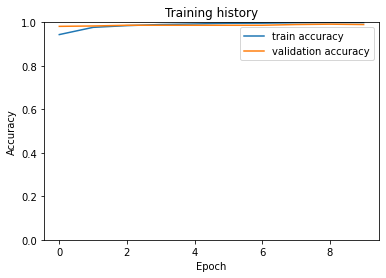

In [33]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [34]:
# 测试数据集精度
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc

0.9866666666666667

In [35]:
# 样本测试
sample_text = "电源插头应按规定正确接线"
encoded_sample_text = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_sample_text['input_ids'].to(device)
attention_mask = encoded_sample_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {class_names[prediction]}')

Sample text: 电源插头应按规定正确接线
Danger label  : 1
